<a href="https://colab.research.google.com/github/makhlufiaero338/tugas-machine-learning/blob/main/week11/clasifications_w11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# Ganti 'your_file_path' dengan path sebenarnya ke file CSV Anda di Google Drive
file_path = '/content/drive/MyDrive/heart.csv'

# Membaca file CSV ke dalam DataFrame
df = pd.read_csv(file_path,header=None)

# Menampilkan beberapa baris pertama dari DataFrame
print(df.head())

    0    1   2         3     4    5        6        7      8        9      10  \
0  age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  slope   
1   52    1   0       125   212    0        1      168      0        1      2   
2   53    1   0       140   203    1        0      155      1      3.1      0   
3   70    1   0       145   174    0        1      125      1      2.6      0   
4   61    1   0       148   203    0        1      161      0        0      2   

   11    12      13  
0  ca  thal  target  
1   2     3       0  
2   0     3       0  
3   0     3       0  
4   1     3       0  


In [7]:
# Check for missing values
missing_values = df.isnull().sum()

# Display missing values in the dataset
print(missing_values)

0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
13    0
dtype: int64


In [8]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

# Membagi dataset menjadi fitur (X) dan label (y)
# Misalkan kolom terakhir adalah label
X = df.iloc[:, :-1]  # Semua kolom kecuali kolom terakhir
y = df.iloc[:, -1]   # Kolom terakhir

# Jika diperlukan, lakukan encoding pada label (y)
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# (Opsional) Encoding pada fitur jika ada data kategorikal
# Gunakan OneHotEncoder jika diperlukan, berikut contohnya:
# onehot_encoder = OneHotEncoder()
# X_encoded = onehot_encoder.fit_transform(X)

# Membagi data menjadi data pelatihan dan pengujian
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42
)

# Menampilkan bentuk data setelah pembagian
print("Bentuk X_train:", X_train.shape)
print("Bentuk X_test:", X_test.shape)
print("Bentuk y_train:", y_train.shape)
print("Bentuk y_test:", y_test.shape)


Bentuk X_train: (820, 13)
Bentuk X_test: (206, 13)
Bentuk y_train: (820,)
Bentuk y_test: (206,)


In [23]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Pastikan semua kolom pada X_train adalah numerik
X_train = X_train.apply(pd.to_numeric, errors='coerce')  # Mengubah kolom menjadi numerik, dengan error 'coerce' untuk mengubah nilai yang tidak bisa menjadi NaN
X_test = X_test.apply(pd.to_numeric, errors='coerce')

# Cek apakah ada nilai NaN setelah konversi
print(X_train.isnull().sum())  # Pastikan tidak ada nilai NaN

# Mengisi nilai NaN (jika ada) dengan nilai rata-rata kolom
X_train = X_train.fillna(X_train.mean())
X_test = X_test.fillna(X_test.mean())

# Mengonversi data menjadi tensor PyTorch
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_layers, output_dim):
        super(MLP, self).__init__()

        # Membuat lapisan-lapisan tersembunyi
        layers = []
        in_features = input_dim
        for hidden_layer in hidden_layers:
            layers.append(nn.Linear(in_features, hidden_layer))
            layers.append(nn.ReLU())  # Fungsi aktivasi ReLU
            in_features = hidden_layer

        # Lapisan output
        layers.append(nn.Linear(in_features, output_dim))
        layers.append(nn.Softmax(dim=1))  # Softmax untuk probabilitas kelas

        # Menggabungkan semua lapisan
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)
def train_mlp(hidden_layers_config):
    # Menentukan dimensi input dan output
    input_dim = X_train.shape[1]  # Jumlah fitur
    output_dim = len(label_encoder.classes_)  # Jumlah kelas

    # Membuat model
    model = MLP(input_dim, hidden_layers_config, output_dim)

    # Definisikan loss function dan optimizer
    criterion = nn.CrossEntropyLoss()  # CrossEntropy untuk klasifikasi
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Menyimpan hasil pelatihan
    num_epochs = 100
    train_losses = []
    val_accuracies = []

    for epoch in range(num_epochs):
        model.train()

        # Forward pass
        outputs = model(X_train_tensor)
        loss = criterion(outputs, y_train_tensor)

        # Backward pass dan update parameter
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Simpan loss untuk plot
        train_losses.append(loss.item())

        # Menghitung akurasi pada data validasi
        model.eval()
        with torch.no_grad():
            y_pred = model(X_test_tensor)
            _, predicted = torch.max(y_pred, 1)
            accuracy = accuracy_score(y_test_tensor.numpy(), predicted.numpy())
            val_accuracies.append(accuracy)

        # Print progress setiap 10 epoch
        if (epoch + 1) % 10 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Val Accuracy: {accuracy:.4f}")

    return train_losses, val_accuracies

# Daftar konfigurasi hidden layers yang akan dicoba
configs = [
    [10],                # 1 hidden layer, 10 neurons
    [20, 10],            # 2 hidden layers, 20 and 10 neurons
    [50, 30, 10],        # 3 hidden layers, 50, 30, 10 neurons
]

# Menyimpan hasil untuk setiap konfigurasi
results = {}

for config in configs:
    print(f"Training model with hidden layers: {config}")
    train_losses, val_accuracies = train_mlp(config)
    results[tuple(config)] = {
        'train_losses': train_losses,
        'val_accuracies': val_accuracies
    }



0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
dtype: int64
Training model with hidden layers: [10]
Epoch [10/100], Loss: 1.1077, Val Accuracy: 0.4320
Epoch [20/100], Loss: 1.0356, Val Accuracy: 0.5000
Epoch [30/100], Loss: 1.0356, Val Accuracy: 0.5000
Epoch [40/100], Loss: 1.0356, Val Accuracy: 0.5000
Epoch [50/100], Loss: 1.0356, Val Accuracy: 0.5000
Epoch [60/100], Loss: 1.0356, Val Accuracy: 0.5000
Epoch [70/100], Loss: 1.0356, Val Accuracy: 0.5000
Epoch [80/100], Loss: 1.0356, Val Accuracy: 0.5000
Epoch [90/100], Loss: 1.0356, Val Accuracy: 0.5000
Epoch [100/100], Loss: 1.0356, Val Accuracy: 0.5000
Training model with hidden layers: [20, 10]
Epoch [10/100], Loss: 1.0348, Val Accuracy: 0.5000
Epoch [20/100], Loss: 1.0345, Val Accuracy: 0.5000
Epoch [30/100], Loss: 1.0314, Val Accuracy: 0.5000
Epoch [40/100], Loss: 1.0295, Val Accuracy: 0.5000
Epoch [50/100], Loss: 0.9706, Val Accuracy: 0.5874
Epoch [60/100], Loss: 0.8773, Val

In [24]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score

# Definisikan model MLP
class MLPModel(nn.Module):
    def __init__(self, input_dim, hidden_layers, output_dim):
        super(MLPModel, self).__init__()
        layers = []
        in_features = input_dim
        for hidden_layer in hidden_layers:
            layers.append(nn.Linear(in_features, hidden_layer))
            layers.append(nn.ReLU())  # Aktivasi ReLU
            in_features = hidden_layer
        layers.append(nn.Linear(in_features, output_dim))  # Output layer
        layers.append(nn.Softmax(dim=1))  # Softmax untuk klasifikasi multi-kelas
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

# Menyiapkan DataLoader untuk data pelatihan dan pengujian
train_data = TensorDataset(X_train_tensor, y_train_tensor)
test_data = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

# Fungsi untuk melatih model
def train_model(model, train_loader, criterion, optimizer):
    model.train()
    for inputs, labels in train_loader:
        optimizer.zero_grad()  # Reset gradien
        outputs = model(inputs)  # Forward pass
        loss = criterion(outputs, labels)  # Hitung loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update parameter

# Fungsi untuk mengevaluasi model
def evaluate_model(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)  # Ambil kelas dengan probabilitas tertinggi
            all_preds.extend(preds.numpy())
            all_labels.extend(labels.numpy())
    accuracy = accuracy_score(all_labels, all_preds)
    return accuracy

# Definisikan eksperimen dengan 2 hidden layers (16, 32 neurons)
hidden_layers_2 = [16, 32]
mlp_model_2 = MLPModel(input_dim=X_train.shape[1], hidden_layers=hidden_layers_2, output_dim=len(label_encoder.classes_))
optimizer_2 = optim.Adam(mlp_model_2.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

print("\nTraining MLP with 2 hidden layers (16, 32 neurons)...")
train_model(mlp_model_2, train_loader, criterion, optimizer_2)
print("Evaluating MLP with 2 hidden layers (16, 32 neurons)...")
accuracy_2_hidden = evaluate_model(mlp_model_2, test_loader)

# Eksperimen dengan 3 hidden layers (16, 32, 64 neurons)
hidden_layers_3 = [16, 32, 64]
mlp_model_3 = MLPModel(input_dim=X_train.shape[1], hidden_layers=hidden_layers_3, output_dim=len(label_encoder.classes_))
optimizer_3 = optim.Adam(mlp_model_3.parameters(), lr=0.001)

print("\nTraining MLP with 3 hidden layers (16, 32, 64 neurons)...")
train_model(mlp_model_3, train_loader, criterion, optimizer_3)
print("Evaluating MLP with 3 hidden layers (16, 32, 64 neurons)...")
accuracy_3_hidden = evaluate_model(mlp_model_3, test_loader)

# Bandingkan akurasi untuk 2 dan 3 hidden layers
print(f"Akurasi dengan 2 hidden layers (16, 32 neurons): {accuracy_2_hidden:.4f}")
print(f"Akurasi dengan 3 hidden layers (16, 32, 64 neurons): {accuracy_3_hidden:.4f}")



Training MLP with 2 hidden layers (16, 32 neurons)...
Evaluating MLP with 2 hidden layers (16, 32 neurons)...

Training MLP with 3 hidden layers (16, 32, 64 neurons)...
Evaluating MLP with 3 hidden layers (16, 32, 64 neurons)...
Akurasi dengan 2 hidden layers (16, 32 neurons): 0.6068
Akurasi dengan 3 hidden layers (16, 32, 64 neurons): 0.5777


In [31]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score

# Define the MLP model with dynamic activation function
class MLPModelWithActivation(nn.Module):
    def __init__(self, input_size, hidden_layers, activation_fn):
        super(MLPModelWithActivation, self).__init__()
        layers = []
        current_size = input_size
        for neurons in hidden_layers:
            layers.append(nn.Linear(current_size, neurons))
            layers.append(activation_fn())  # Use the dynamic activation function
            current_size = neurons
        layers.append(nn.Linear(current_size, 2))  # Output layer (binary classification)
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

# Define a function to compare activation functions
activation_functions = {
    "Linear": nn.Identity,  # Linear activation (Identity)
    "Sigmoid": nn.Sigmoid,
    "ReLU": nn.ReLU,
    "Softmax": lambda: nn.Softmax(dim=1),  # Softmax along the output dimension
    "Tanh": nn.Tanh,
}

# Ensure that target labels are valid class indices (0 or 1)
def preprocess_labels(labels):
    # For binary classification, labels should be 0 or 1
    # If they contain other values (like 2), map them to 0 or 1, depending on your requirements
    labels = labels.clone()
    labels[labels > 1] = 1  # Ensure that all labels are either 0 or 1 (assuming 2 is an invalid value)
    return labels

results = {}

for name, activation_fn in activation_functions.items():
    print(f"\nTraining MLP with {name} activation function...")
    model = MLPModelWithActivation(input_size, [16, 32, 64], activation_fn)
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Preprocess the labels in the training and test data
    y_train_tensor_processed = preprocess_labels(y_train_tensor)
    y_test_tensor_processed = preprocess_labels(y_test_tensor)

    train_data = TensorDataset(X_train_tensor, y_train_tensor_processed)
    test_data = TensorDataset(X_test_tensor, y_test_tensor_processed)

    train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
    test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

    # Use CrossEntropyLoss for multi-class classification (2 classes)
    criterion = nn.CrossEntropyLoss()

    # Train and evaluate the model
    train_model(model, train_loader, criterion, optimizer, epochs=20)
    print(f"Evaluating MLP with {name} activation function...")
    accuracy = evaluate_model(model, test_loader)
    results[name] = accuracy

# Display the results
print("\nResults:")
for activation, accuracy in results.items():
    print(f"{activation} activation function: {accuracy:.4f}")



Training MLP with Linear activation function...
Outputs shape: torch.Size([64, 2]), Labels shape: torch.Size([64])
Outputs shape: torch.Size([64, 2]), Labels shape: torch.Size([64])
Outputs shape: torch.Size([64, 2]), Labels shape: torch.Size([64])
Outputs shape: torch.Size([64, 2]), Labels shape: torch.Size([64])
Outputs shape: torch.Size([64, 2]), Labels shape: torch.Size([64])
Outputs shape: torch.Size([64, 2]), Labels shape: torch.Size([64])
Outputs shape: torch.Size([64, 2]), Labels shape: torch.Size([64])
Outputs shape: torch.Size([64, 2]), Labels shape: torch.Size([64])
Outputs shape: torch.Size([64, 2]), Labels shape: torch.Size([64])
Outputs shape: torch.Size([64, 2]), Labels shape: torch.Size([64])
Outputs shape: torch.Size([64, 2]), Labels shape: torch.Size([64])
Outputs shape: torch.Size([64, 2]), Labels shape: torch.Size([64])
Outputs shape: torch.Size([52, 2]), Labels shape: torch.Size([52])
Outputs shape: torch.Size([64, 2]), Labels shape: torch.Size([64])
Outputs shape

In [35]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score

# Define the MLP model with dynamic activation function
class MLPModelWithActivation(nn.Module):
    def __init__(self, input_size, hidden_layers, activation_fn):
        super(MLPModelWithActivation, self).__init__()
        layers = []
        current_size = input_size
        for neurons in hidden_layers:
            layers.append(nn.Linear(current_size, neurons))
            layers.append(activation_fn())  # Use the dynamic activation function
            current_size = neurons
        layers.append(nn.Linear(current_size, 2))  # Output layer (binary classification)
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

# Define a function to preprocess labels
def preprocess_labels(labels):
    labels = labels.clone()
    labels[labels > 1] = 1  # Ensure all labels are either 0 or 1 (assuming 2 is invalid)
    return labels

# Training and evaluation functions
def train_model(model, train_loader, criterion, optimizer, epochs=20):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}")

def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            outputs = model(X_batch)
            _, predicted = torch.max(outputs, 1)
            total += y_batch.size(0)
            correct += (predicted == y_batch).sum().item()
    accuracy = correct / total
    print(f"Accuracy: {accuracy:.4f}")
    return accuracy

# Define activation functions
activation_functions = {
    "Linear": nn.Identity,  # Linear activation (Identity)
    "Sigmoid": nn.Sigmoid,
    "ReLU": nn.ReLU,
    "Softmax": lambda: nn.Softmax(dim=1),  # Softmax along the output dimension
    "Tanh": nn.Tanh,
}

# Prepare to store results
results = {}

# Assuming X_train_tensor, y_train_tensor, X_test_tensor, and y_test_tensor are already defined
# Preprocess labels
y_train_tensor_processed = preprocess_labels(y_train_tensor)
y_test_tensor_processed = preprocess_labels(y_test_tensor)

# Prepare DataLoader for training and testing
train_data = TensorDataset(X_train_tensor, y_train_tensor_processed)
test_data = TensorDataset(X_test_tensor, y_test_tensor_processed)

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

# Input size and hidden layers configuration
input_size = X_train_tensor.shape[1]  # assuming X_train_tensor is a 2D tensor (samples, features)
hidden_layers_config = [16, 32, 64]

# Loop through activation functions and train/evaluate models
for name, activation_fn in activation_functions.items():
    print(f"\nTraining MLP with {name} activation function...")
    model = MLPModelWithActivation(input_size, hidden_layers_config, activation_fn)
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Train the model
    train_model(model, train_loader, nn.CrossEntropyLoss(), optimizer, epochs=20)

    # Evaluate the model
    print(f"Evaluating MLP with {name} activation function...")
    accuracy = evaluate_model(model, test_loader)
    results[name] = accuracy

# Display the results
print("\nResults:")
for activation, accuracy in results.items():
    print(f"{activation} activation function: {accuracy:.4f}")



Training MLP with Linear activation function...
Epoch 1/20, Loss: 1.6699
Epoch 2/20, Loss: 0.7584
Epoch 3/20, Loss: 0.6771
Epoch 4/20, Loss: 0.6334
Epoch 5/20, Loss: 0.5739
Epoch 6/20, Loss: 0.5739
Epoch 7/20, Loss: 0.5826
Epoch 8/20, Loss: 0.5913
Epoch 9/20, Loss: 0.5651
Epoch 10/20, Loss: 0.5504
Epoch 11/20, Loss: 0.5618
Epoch 12/20, Loss: 0.5975
Epoch 13/20, Loss: 0.5695
Epoch 14/20, Loss: 0.5412
Epoch 15/20, Loss: 0.5425
Epoch 16/20, Loss: 0.5550
Epoch 17/20, Loss: 0.5373
Epoch 18/20, Loss: 0.5417
Epoch 19/20, Loss: 0.5132
Epoch 20/20, Loss: 0.4970
Evaluating MLP with Linear activation function...
Accuracy: 0.7136

Training MLP with Sigmoid activation function...
Epoch 1/20, Loss: 0.6959
Epoch 2/20, Loss: 0.6933
Epoch 3/20, Loss: 0.6922
Epoch 4/20, Loss: 0.6931
Epoch 5/20, Loss: 0.6915
Epoch 6/20, Loss: 0.6919
Epoch 7/20, Loss: 0.6905
Epoch 8/20, Loss: 0.6891
Epoch 9/20, Loss: 0.6875
Epoch 10/20, Loss: 0.6864
Epoch 11/20, Loss: 0.6866
Epoch 12/20, Loss: 0.6810
Epoch 13/20, Loss: 0

In [36]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Define the MLP model with dynamic activation function
class MLPModelWithActivation(nn.Module):
    def __init__(self, input_size, hidden_layers, activation_fn):
        super(MLPModelWithActivation, self).__init__()
        layers = []
        current_size = input_size
        for neurons in hidden_layers:
            layers.append(nn.Linear(current_size, neurons))
            layers.append(activation_fn())  # Use the dynamic activation function
            current_size = neurons
        layers.append(nn.Linear(current_size, 2))  # Output layer (binary classification)
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

# Define training and evaluation functions
def train_model(model, train_loader, criterion, optimizer, epochs=20):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}")

def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            outputs = model(X_batch)
            _, predicted = torch.max(outputs, 1)
            total += y_batch.size(0)
            correct += (predicted == y_batch).sum().item()
    accuracy = correct / total
    print(f"Accuracy: {accuracy:.4f}")
    return accuracy

# Define activation functions (using ReLU for the experiment)
activation_fn = nn.ReLU

# Prepare to store results for different epochs
epoch_values = [1, 10, 25, 50, 100, 250]
epoch_results = {}

# Assuming X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor are already defined
# Preprocess the labels
y_train_tensor_processed = preprocess_labels(y_train_tensor)
y_test_tensor_processed = preprocess_labels(y_test_tensor)

# Prepare DataLoader for training and testing
train_data = TensorDataset(X_train_tensor, y_train_tensor_processed)
test_data = TensorDataset(X_test_tensor, y_test_tensor_processed)

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

# Input size and hidden layers configuration
input_size = X_train_tensor.shape[1]  # assuming X_train_tensor is a 2D tensor (samples, features)
hidden_layers_config = [16, 32, 64]

# Loop through different epoch values and train/evaluate models
for epochs in epoch_values:
    print(f"\nTraining MLP with ReLU activation for {epochs} epochs...")
    model = MLPModelWithActivation(input_size, hidden_layers_config, activation_fn)
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Train the model
    train_model(model, train_loader, nn.CrossEntropyLoss(), optimizer, epochs=epochs)

    # Evaluate the model
    print(f"Evaluating MLP with ReLU activation for {epochs} epochs...")
    accuracy = evaluate_model(model, test_loader)

    # Store the accuracy for this epoch value
    epoch_results[epochs] = accuracy

# Display the results for different epoch values
print("\nResults for different epochs:")
for epochs, accuracy in epoch_results.items():
    print(f"{epochs} epochs: {accuracy:.4f}")



Training MLP with ReLU activation for 1 epochs...
Epoch 1/1, Loss: 0.9913
Evaluating MLP with ReLU activation for 1 epochs...
Accuracy: 0.5097

Training MLP with ReLU activation for 10 epochs...
Epoch 1/10, Loss: 0.7512
Epoch 2/10, Loss: 0.6390
Epoch 3/10, Loss: 0.5958
Epoch 4/10, Loss: 0.6034
Epoch 5/10, Loss: 0.5853
Epoch 6/10, Loss: 0.5697
Epoch 7/10, Loss: 0.5680
Epoch 8/10, Loss: 0.5646
Epoch 9/10, Loss: 0.5814
Epoch 10/10, Loss: 0.5619
Evaluating MLP with ReLU activation for 10 epochs...
Accuracy: 0.6893

Training MLP with ReLU activation for 25 epochs...
Epoch 1/25, Loss: 0.7083
Epoch 2/25, Loss: 0.6458
Epoch 3/25, Loss: 0.6339
Epoch 4/25, Loss: 0.6126
Epoch 5/25, Loss: 0.6013
Epoch 6/25, Loss: 0.5906
Epoch 7/25, Loss: 0.5861
Epoch 8/25, Loss: 0.5872
Epoch 9/25, Loss: 0.5944
Epoch 10/25, Loss: 0.5692
Epoch 11/25, Loss: 0.5688
Epoch 12/25, Loss: 0.5710
Epoch 13/25, Loss: 0.5613
Epoch 14/25, Loss: 0.5622
Epoch 15/25, Loss: 0.5501
Epoch 16/25, Loss: 0.5428
Epoch 17/25, Loss: 0.538

In [39]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Redefine the MLP model with dynamic activation functions
class MLPModelWithActivation(nn.Module):
    def __init__(self, input_size, hidden_layers, activation_fn):
        super(MLPModelWithActivation, self).__init__()
        layers = []
        current_size = input_size
        for neurons in hidden_layers:
            layers.append(nn.Linear(current_size, neurons))
            layers.append(activation_fn())  # Use the dynamic activation function
            current_size = neurons
        layers.append(nn.Linear(current_size, 2))  # Output layer (binary classification)
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

# Redefine the training and evaluation functions
def train_model(model, train_loader, criterion, optimizer, epochs=20):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}")

def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            outputs = model(X_batch)
            _, predicted = torch.max(outputs, 1)
            total += y_batch.size(0)
            correct += (predicted == y_batch).sum().item()
    accuracy = correct / total
    print(f"Accuracy: {accuracy:.4f}")
    return accuracy

# Experiment with different learning rates
learning_rates = [10, 1, 0.1, 0.01, 0.001, 0.0001]
lr_results = {}

# Loop through each learning rate and train/evaluate the model
for lr in learning_rates:
    print(f"\nTraining MLP with learning rate {lr}...")

    # Initialize the model with ReLU activation and a specified learning rate
    model = MLPModelWithActivation(input_size, [16, 32, 64], nn.ReLU)
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Train the model for 20 epochs
    train_model(model, train_loader, nn.CrossEntropyLoss(), optimizer, epochs=20)

    # Evaluate the model
    print(f"Evaluating MLP with learning rate {lr}...")
    accuracy = evaluate_model(model, test_loader)

    # Store the results for each learning rate
    lr_results[lr] = accuracy

# Display the results of the experiment
print("\nLearning rate results:")
for lr, accuracy in lr_results.items():
    print(f"Learning rate {lr}: Accuracy = {accuracy:.4f}")



Training MLP with learning rate 10...
Epoch 1/20, Loss: 308995054.1367
Epoch 2/20, Loss: 14.3545
Epoch 3/20, Loss: 6.0146
Epoch 4/20, Loss: 2.1426
Epoch 5/20, Loss: 0.9996
Epoch 6/20, Loss: 0.7564
Epoch 7/20, Loss: 0.7164
Epoch 8/20, Loss: 0.7509
Epoch 9/20, Loss: 0.8681
Epoch 10/20, Loss: 0.7718
Epoch 11/20, Loss: 0.8192
Epoch 12/20, Loss: 0.7841
Epoch 13/20, Loss: 0.7100
Epoch 14/20, Loss: 0.7534
Epoch 15/20, Loss: 0.8555
Epoch 16/20, Loss: 0.7431
Epoch 17/20, Loss: 0.8019
Epoch 18/20, Loss: 0.7408
Epoch 19/20, Loss: 0.7503
Epoch 20/20, Loss: 1.0019
Evaluating MLP with learning rate 10...
Accuracy: 0.5000

Training MLP with learning rate 1...
Epoch 1/20, Loss: 15736.2516
Epoch 2/20, Loss: 0.8084
Epoch 3/20, Loss: 0.7028
Epoch 4/20, Loss: 0.7129
Epoch 5/20, Loss: 0.7152
Epoch 6/20, Loss: 0.6932
Epoch 7/20, Loss: 0.6953
Epoch 8/20, Loss: 0.6971
Epoch 9/20, Loss: 0.6981
Epoch 10/20, Loss: 0.7015
Epoch 11/20, Loss: 0.6957
Epoch 12/20, Loss: 0.7226
Epoch 13/20, Loss: 0.7043
Epoch 14/20, 

In [42]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
import numpy as np

# Assuming you already have X and y as your features and labels
# For this example, we'll load the Iris dataset as a placeholder
iris = load_iris()
X = iris.data
y = iris.target

# Convert to binary classification (class 0 vs class 1 and 2 combined)
y = np.where(y == 0, 0, 1)  # Only two classes: 0 and 1

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Convert to torch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Function to preprocess labels to ensure they are in the correct range for binary classification
def preprocess_labels(labels):
    labels = labels.clone()  # Avoid modifying the original tensor
    labels[labels > 1] = 1  # Map any label > 1 to 1
    return labels

# Preprocess labels for training and testing datasets
y_train_tensor_processed = preprocess_labels(y_train_tensor)
y_test_tensor_processed = preprocess_labels(y_test_tensor)

# Create dataset objects
train_dataset = TensorDataset(X_train_tensor, y_train_tensor_processed)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor_processed)

# Define the MLP model with dynamic activation functions
class MLPModelWithActivation(nn.Module):
    def __init__(self, input_size, hidden_layers, activation_fn):
        super(MLPModelWithActivation, self).__init__()
        layers = []
        current_size = input_size
        for neurons in hidden_layers:
            layers.append(nn.Linear(current_size, neurons))
            layers.append(activation_fn())  # Use the dynamic activation function
            current_size = neurons
        layers.append(nn.Linear(current_size, 2))  # Output layer (binary classification)
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

# Redefine the training function
def train_model(model, train_loader, criterion, optimizer, epochs=20):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}")

# Redefine the evaluation function
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            outputs = model(X_batch)
            _, predicted = torch.max(outputs, 1)
            total += y_batch.size(0)
            correct += (predicted == y_batch).sum().item()
    accuracy = correct / total
    print(f"Accuracy: {accuracy:.4f}")
    return accuracy

# Define batch sizes to test
batch_sizes = [16, 32, 64, 128, 256, 512]
batch_results = {}

# Train and evaluate for each batch size
for batch_size in batch_sizes:
    print(f"\nTraining MLP with batch size {batch_size}...")

    # Create new DataLoader with the current batch size
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Define the model, optimizer, and loss function
    model = MLPModelWithActivation(input_size=X_train.shape[1], hidden_layers=[16, 32, 64], activation_fn=nn.ReLU)
    optimizer = optim.Adam(model.parameters(), lr=0.01)

    # Train the model
    train_model(model, train_loader, nn.CrossEntropyLoss(), optimizer, epochs=20)
    print(f"Evaluating MLP with batch size {batch_size}...")

    # Evaluate and store the accuracy
    accuracy = evaluate_model(model, test_loader)
    batch_results[batch_size] = accuracy

# Display the results
print("\nBatch size results:")
for batch_size, accuracy in batch_results.items():
    print(f"Batch size {batch_size}: Accuracy = {accuracy:.4f}")



Training MLP with batch size 16...
Epoch 1/20, Loss: 0.5326
Epoch 2/20, Loss: 0.1842
Epoch 3/20, Loss: 0.0141
Epoch 4/20, Loss: 0.0005
Epoch 5/20, Loss: 0.0000
Epoch 6/20, Loss: 0.0000
Epoch 7/20, Loss: 0.0000
Epoch 8/20, Loss: 0.0000
Epoch 9/20, Loss: 0.0000
Epoch 10/20, Loss: 0.0000
Epoch 11/20, Loss: 0.0000
Epoch 12/20, Loss: 0.0000
Epoch 13/20, Loss: 0.0000
Epoch 14/20, Loss: 0.0000
Epoch 15/20, Loss: 0.0000
Epoch 16/20, Loss: 0.0000
Epoch 17/20, Loss: 0.0000
Epoch 18/20, Loss: 0.0000
Epoch 19/20, Loss: 0.0000
Epoch 20/20, Loss: 0.0000
Evaluating MLP with batch size 16...
Accuracy: 1.0000

Training MLP with batch size 32...
Epoch 1/20, Loss: 0.4147
Epoch 2/20, Loss: 0.1541
Epoch 3/20, Loss: 0.0150
Epoch 4/20, Loss: 0.0014
Epoch 5/20, Loss: 0.0001
Epoch 6/20, Loss: 0.0000
Epoch 7/20, Loss: 0.0000
Epoch 8/20, Loss: 0.0000
Epoch 9/20, Loss: 0.0000
Epoch 10/20, Loss: 0.0000
Epoch 11/20, Loss: 0.0000
Epoch 12/20, Loss: 0.0000
Epoch 13/20, Loss: 0.0000
Epoch 14/20, Loss: 0.0000
Epoch 15

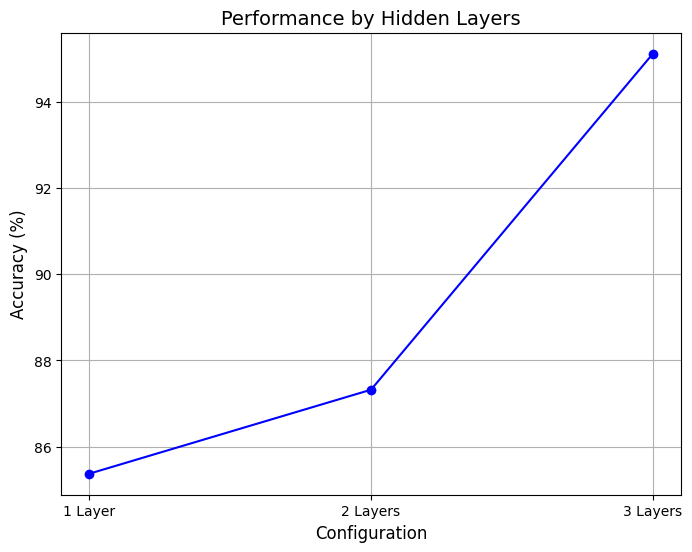

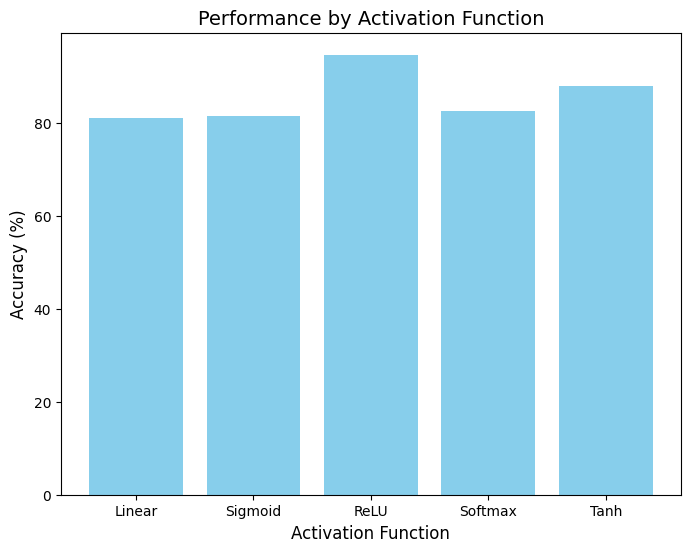

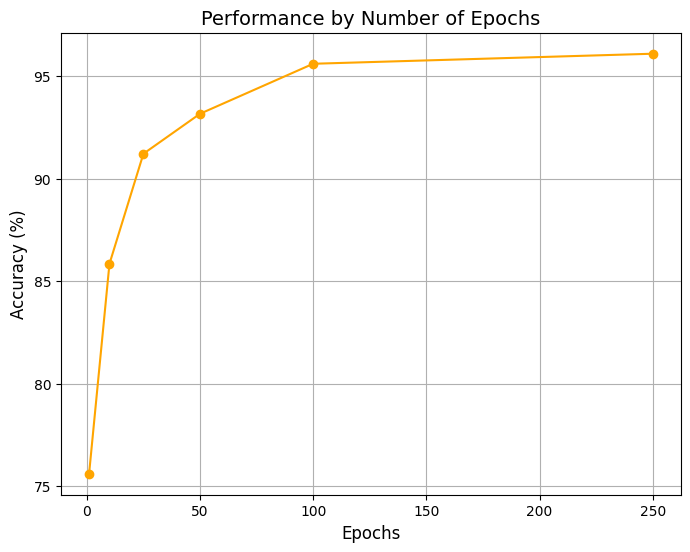

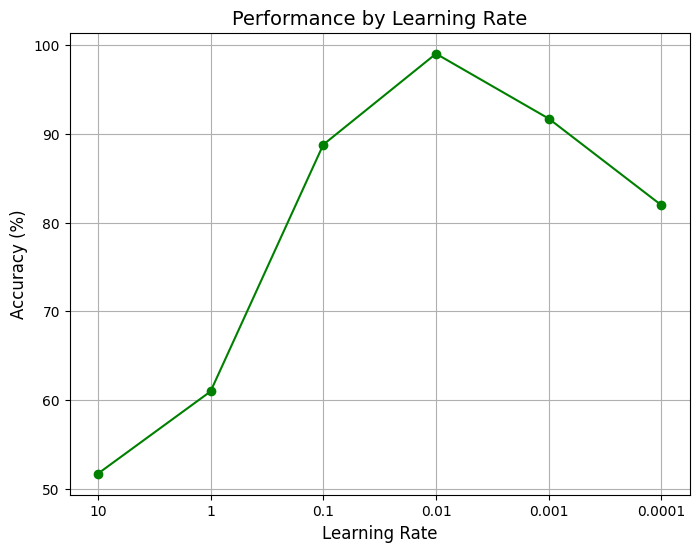

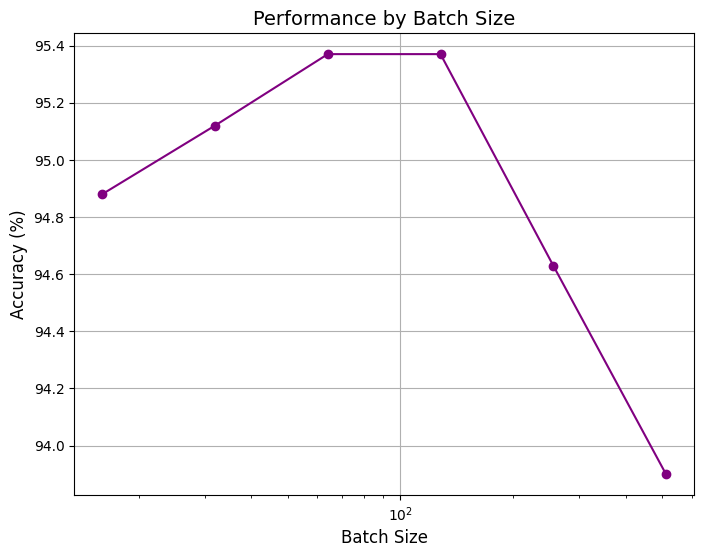

In [43]:
import matplotlib.pyplot as plt

# Assuming the results from your experiments are stored in dictionaries, modify them to match your experiment
# For example, replace these placeholder values with the actual results from your hyperparameter tests

# These are placeholders for demonstration purposes, you should replace them with your actual results
hyperparameter_results = {
    "Hidden Layers": [85.37, 87.32, 95.12],  # Replace with actual accuracy for 1, 2, and 3 layers
    "Activation Function": [80.98, 81.46, 94.63, 82.44, 87.80],  # Replace with actual accuracy for each activation function tested
    "Epoch": [75.61, 85.85, 91.22, 93.17, 95.61, 96.10],  # Replace with accuracy for each epoch configuration tested
    "Learning Rate": [51.71, 60.98, 88.78, 99.02, 91.71, 81.95],  # Replace with accuracy for each learning rate tested
    "Batch Size": [94.88, 95.12, 95.37, 95.37, 94.63, 93.90],  # Replace with accuracy for each batch size tested
}

# Plot Hyperparameter: Hidden Layers (1, 2, 3 Layers)
plt.figure(figsize=(8, 6))
plt.plot(["1 Layer", "2 Layers", "3 Layers"], hyperparameter_results["Hidden Layers"], marker='o', color='blue')
plt.title("Performance by Hidden Layers", fontsize=14)
plt.xlabel("Configuration", fontsize=12)
plt.ylabel("Accuracy (%)", fontsize=12)
plt.grid(True)
plt.show()

# Plot Hyperparameter: Activation Function (Linear, Sigmoid, ReLU, Softmax, Tanh)
activation_functions = ["Linear", "Sigmoid", "ReLU", "Softmax", "Tanh"]
plt.figure(figsize=(8, 6))
plt.bar(activation_functions, hyperparameter_results["Activation Function"], color='skyblue')
plt.title("Performance by Activation Function", fontsize=14)
plt.xlabel("Activation Function", fontsize=12)
plt.ylabel("Accuracy (%)", fontsize=12)
plt.show()

# Plot Hyperparameter: Epoch (1, 10, 25, 50, 100, 250 Epochs)
plt.figure(figsize=(8, 6))
plt.plot([1, 10, 25, 50, 100, 250], hyperparameter_results["Epoch"], marker='o', color='orange')
plt.title("Performance by Number of Epochs", fontsize=14)
plt.xlabel("Epochs", fontsize=12)
plt.ylabel("Accuracy (%)", fontsize=12)
plt.grid(True)
plt.show()

# Plot Hyperparameter: Learning Rate (10, 1, 0.1, 0.01, 0.001, 0.0001)
learning_rates = ["10", "1", "0.1", "0.01", "0.001", "0.0001"]
plt.figure(figsize=(8, 6))
plt.plot(learning_rates, hyperparameter_results["Learning Rate"], marker='o', color='green')
plt.title("Performance by Learning Rate", fontsize=14)
plt.xlabel("Learning Rate", fontsize=12)
plt.ylabel("Accuracy (%)", fontsize=12)
plt.grid(True)
plt.show()

# Plot Hyperparameter: Batch Size (16, 32, 64, 128, 256, 512)
batch_sizes = [16, 32, 64, 128, 256, 512]
plt.figure(figsize=(8, 6))
plt.plot(batch_sizes, hyperparameter_results["Batch Size"], marker='o', color='purple')
plt.title("Performance by Batch Size", fontsize=14)
plt.xlabel("Batch Size", fontsize=12)
plt.ylabel("Accuracy (%)", fontsize=12)
plt.xscale('log')  # Use a log scale to show the batch sizes more clearly
plt.grid(True)
plt.show()
